# Cargando ECG y extrayendo el espectrograma:

In [1]:
import numpy as np  #Calculos
from scipy import signal #Para la implementación defiltros
from scipy.signal import filtfilt, butter, kaiserord, lfilter, firwin , iirnotch#Filtros
from scipy.fft import fftshift 
from matplotlib import mlab
import matplotlib.pyplot as plt #Para graficar señales
import wfdb # Tratar BD MIT

In [2]:
def FIRRemoveBL(ecgy, Fs, Fc, factor):
    
    """ Funcion que define el filtro FIR
    ecgy: la señal contaminada (debe ser una lista)
    Fc: frecuencia de corte
    Fs: frecuencia de muestreo
    ECG_Clean : señal procesada sin ruido de linea base"""
    
    # Se obtiene el tamaño de la señal de entrada
    signal_len = len(ecgy)
    
    # La frecuencia de Nyquist de la señal.
    nyq_rate = Fs / 2.0
    
    # El ancho deseado de la transición de stop a pass,relativo a la tasa de Nyquist.
    width = 0.07/nyq_rate 
    
    # Atenuación en la stopband del filtro, en dB.
    # relacionado con desarrolladores en Matlab. En Matlab está en proporción
    ripple_db = round(-20*np.log10(0.001))+1
    ripple_db = ripple_db / factor

    
    # Calcula el orden y el parámetro Kaiser para el filtro FIR.
    N, beta = kaiserord(ripple_db, width)
       
    # Uso de la funcion firwin con una ventana Kaiser para crear un filtro FIR de paso alto.
    h = firwin(N, Fc/nyq_rate, window=('kaiser', beta), pass_zero='highpass')

    # Comprobar la condición del filtro
    if N*3 > signal_len:
        diff = N*3 - signal_len
        ecgy = list(reversed(ecgy)) + list(ecgy) + list(ecgy[-1] * np.ones(diff))
        
        # Filtrando con filtfilt
        # Esta función aplica un filtro digital lineal dos veces, una hacia adelante y otra hacia atrás. 
        # El filtro combinado tiene fase cero y un orden de filtrado el doble que el original.
        ECG_Clean = filtfilt(h, 1.0, ecgy)
        ECG_Clean = ECG_Clean[signal_len: signal_len + signal_len]
    else:
        # Filtrando con filtfilt
        ECG_Clean = filtfilt(h, 1.0, ecgy)
    
    return ECG_Clean, N
#Filtro paso bajos Para filtrar el ruido de alta frecuencia
def butter_lowpass_filter(data, cutoff, freq_muestreo, order=5):
    """Función para aplicar filtro pasabaja a la señal ECG con la finalidad
       de eliminar el ruido de alta frecuencia."""
    cutoff=(2*cutoff)/freq_muestreo #frecuencia de corte en rad/s
    b, a = butter(order,cutoff,btype='low',fs=freq_muestreo)
    y = lfilter(b, a, data)
    return y
def graph_spectrogram(ecg,fs):
    """Esta función extrae la matriz de datos del espectrograma de la señal"""
    
    nfft = 164 # Length of each window segment
    noverlap = 135 # Overlap between windows
    nchannels = ecg.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(ecg, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(ecg[:,0], nfft, fs, noverlap = noverlap)
    return pxx


def funcion_filtro_normalizacion_FA(paciente,data_path):
    """Esta funcion se usa para aplicar los filtros y normalizar las señal del ECG"""
    
    #Extracción de las dos señales 
    grabacion=wfdb.rdrecord(data_path+paciente)
    senal_ecg_original=grabacion.p_signal
    #Extrayendo los dos canales de la señal
    senal_ecg_canal_I=senal_ecg_original[:,0].reshape(-1)
    senal_ecg_canal_II=senal_ecg_original[:,1].reshape(-1)

    # Parameters
    Fs = 360 # Frecuencia de muestreo
    Fc = 0.67 # Recomendada en la bibliografia
    factor = 2
    
    #Filtrado de eliminación de línea base de la señal ECG
    senal_ecg_filtrada_FIR_I,N=FIRRemoveBL(senal_ecg_canal_I,Fs,Fc,factor) #implementación filtro FIR
    senal_ecg_filtrada_FIR_II,N=FIRRemoveBL(senal_ecg_canal_II,Fs,Fc,factor) #implementación filtro FIR

    #Filtro para suavizar la señal eliminando altas frecuencias
    senal_ecg_I_filtrada=butter_lowpass_filter(senal_ecg_filtrada_FIR_I,4500,Fs,order=1)#Se filtra el primer canal de la señal Frecuencia de corte = 4500 Hz
    senal_ecg_II_filtrada=butter_lowpass_filter(senal_ecg_filtrada_FIR_II,4500,Fs,order=1)#Se filtra el primer canal de la señal Frecuencia de corte = 4500 Hz

    #Normalización de la señal (implementar normalizacion estandar)
    maximo_I=max(abs(senal_ecg_I_filtrada))
    maximo_II=max(abs(senal_ecg_II_filtrada))
    print("El maximo 1: "+str(maximo_I)+" El maximo 2: "+str(maximo_II))
    senal_ecg_I_filtrada_N=senal_ecg_I_filtrada/maximo_I
    senal_ecg_II_filtrada_N=senal_ecg_II_filtrada/maximo_II
    
    return senal_ecg_I_filtrada_N,senal_ecg_II_filtrada_N

# Extracción de la señal

In [3]:
corte_inferior,corte_superior=0,2000
data_path='C:\\Users\\jdani\\Documents\\Escritorio\\Universidad\\Trabajo de grado\\BaseDeDatos\\mit_bih_arrhythmiadatabase\\'
#Se aplica filtro de linea base y filtro de alta frecuencia
senal_ecg_canal_I_Normal,senal_ecg_canal_II_Normal=funcion_filtro_normalizacion_FA('113',data_path)

# Implementación del filtro notch en los dos canales
notch_freq= 60 # Hz
quality_factor=20.0
samp_freq=360 # Hz
b_notch, a_notch = signal.iirnotch(notch_freq, quality_factor, samp_freq)
senal_ecg_I_filtrada = signal.filtfilt(b_notch, a_notch, senal_ecg_canal_I_Normal)
senal_ecg_II_filtrada = signal.filtfilt(b_notch, a_notch, senal_ecg_canal_II_Normal)

nfft = 164  # Length of each window segment
noverlap = 135  # Overlap between windows





El maximo 1: 2.0927512145983678 El maximo 2: 0.8372844764893119


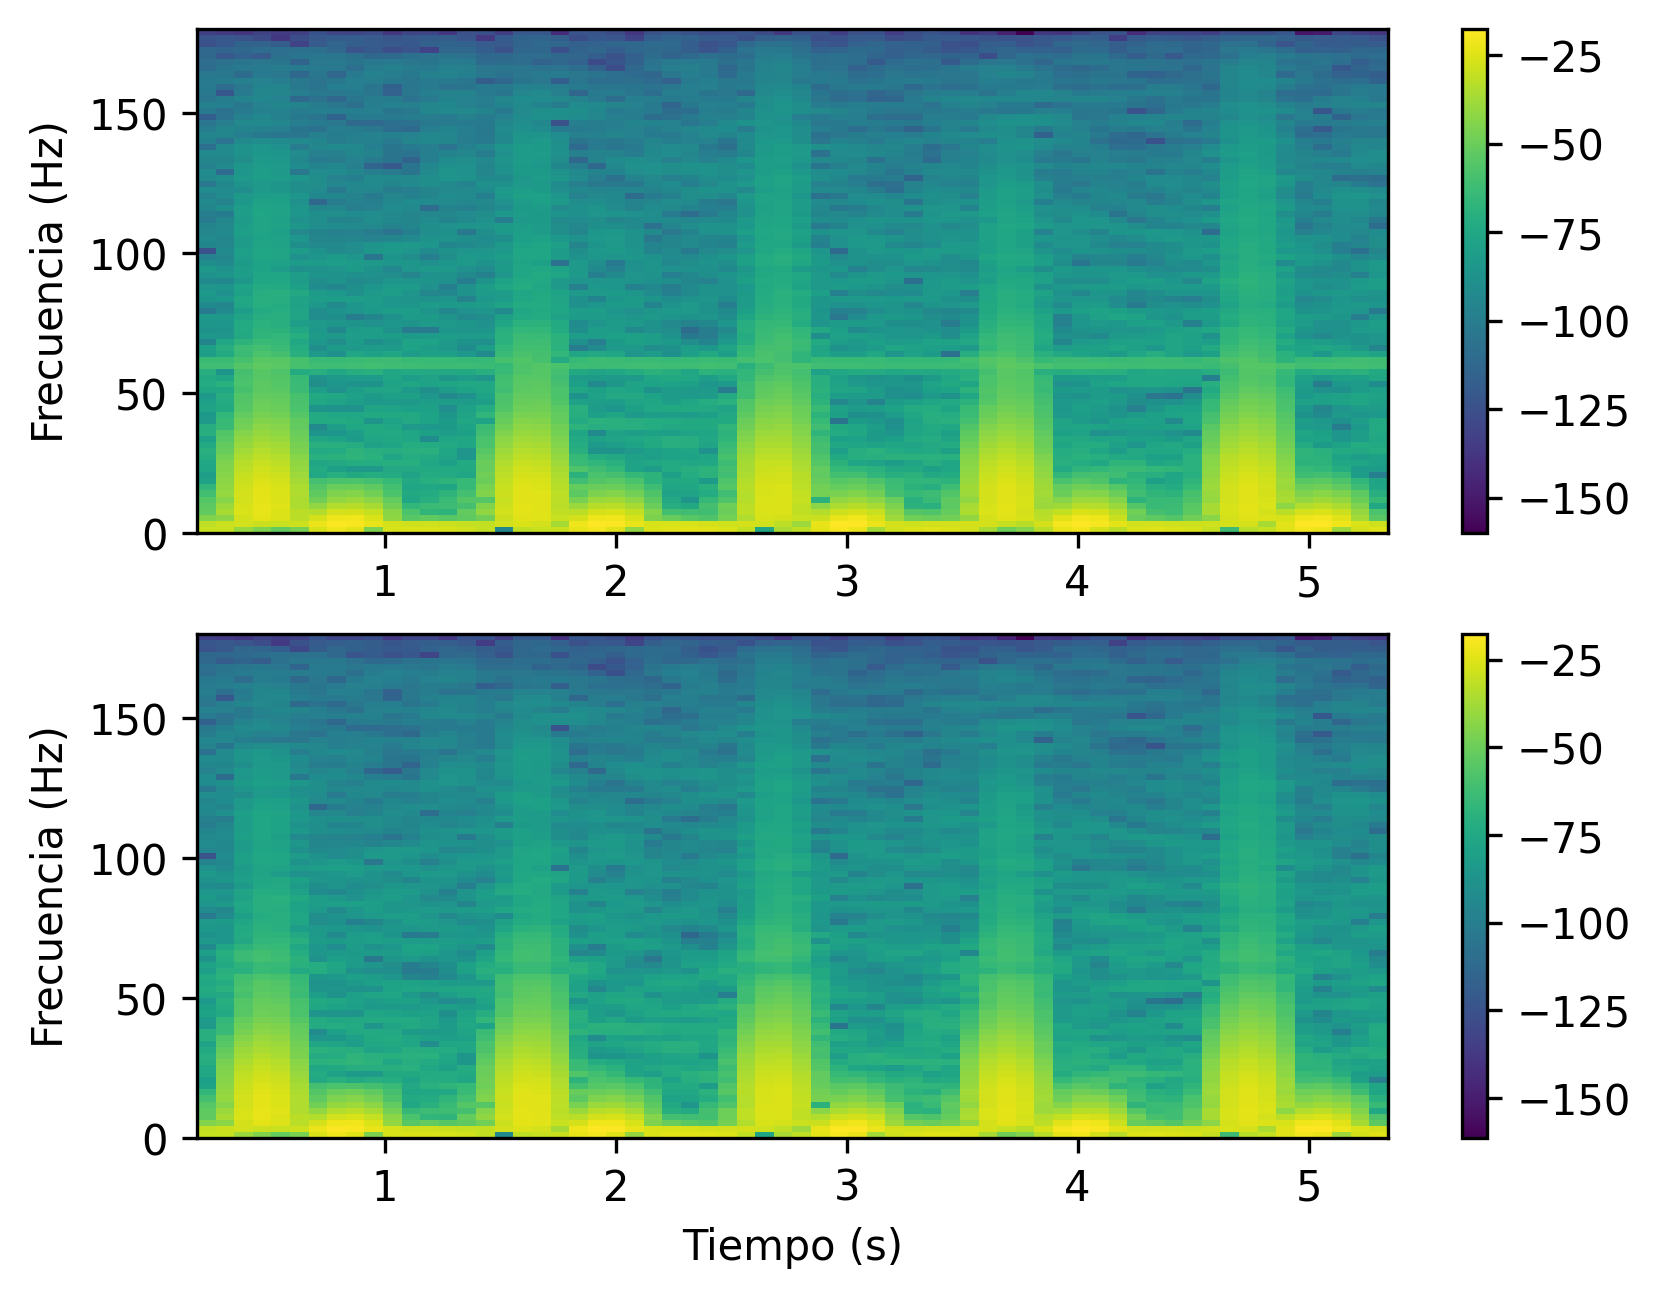

In [6]:
senal_ecg_I_filtrada[corte_inferior:corte_superior]
fig, (ax1, ax2) = plt.subplots(nrows=2,dpi=300)
pxx, freqs, bins, im = ax1.specgram(senal_ecg_canal_I_Normal[corte_inferior:corte_superior], nfft, 360, noverlap=noverlap)
ax1.set_ylabel('Frecuencia (Hz)')
plt.colorbar(im)
pxx, freqs, bins, im = ax2.specgram(senal_ecg_I_filtrada[corte_inferior:corte_superior], nfft, 360, noverlap=noverlap)
ax2.set_ylabel('Frecuencia (Hz)')
ax2.set_xlabel('Tiempo (s)')
# The `specgram` method returns 4 objects. They are:
# - Pxx: the periodogram
# - freqs: the frequency vector
# - bins: the centers of the time bins
# - im: the .image.AxesImage instance representing the data in the plot
plt.colorbar(im)
plt.savefig("ImagenesGuardadas\\FiltroNotch2.png",dpi=300)
plt.show()

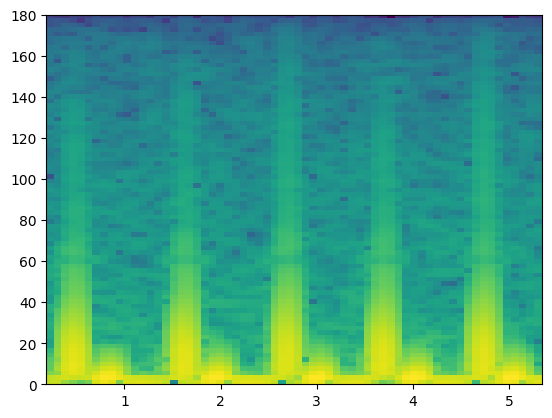

In [4]:
# Implementación del filtro notch en los dos canales
notch_freq= 60 # Hz
quality_factor=20.0
samp_freq=360 # Hz
b_notch, a_notch = signal.iirnotch(notch_freq, quality_factor, samp_freq)
senal_ecg_I_filtrada = signal.filtfilt(b_notch, a_notch, senal_ecg_canal_I_Normal)
senal_ecg_II_filtrada = signal.filtfilt(b_notch, a_notch, senal_ecg_canal_II_Normal)

#Canal 1 despues del filtro notch
a=graph_spectrogram(senal_ecg_I_filtrada[corte_inferior:corte_superior],360)

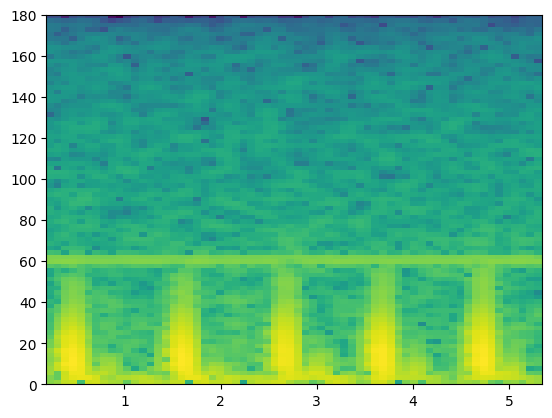

In [5]:
# Espectrograma del canal 2
a=graph_spectrogram(senal_ecg_canal_II_Normal[corte_inferior:corte_superior],360)

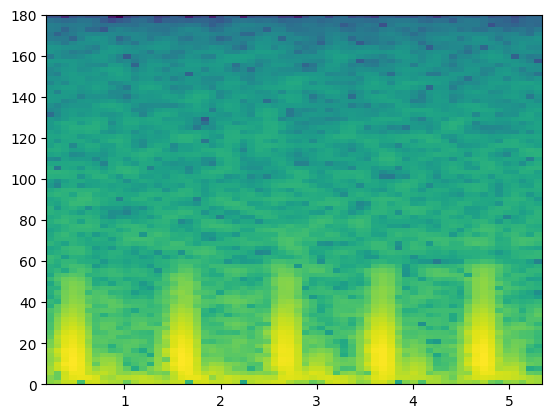

In [6]:
#Canal 2 despues del filtro notch
a=graph_spectrogram(senal_ecg_II_filtrada[corte_inferior:corte_superior],360)

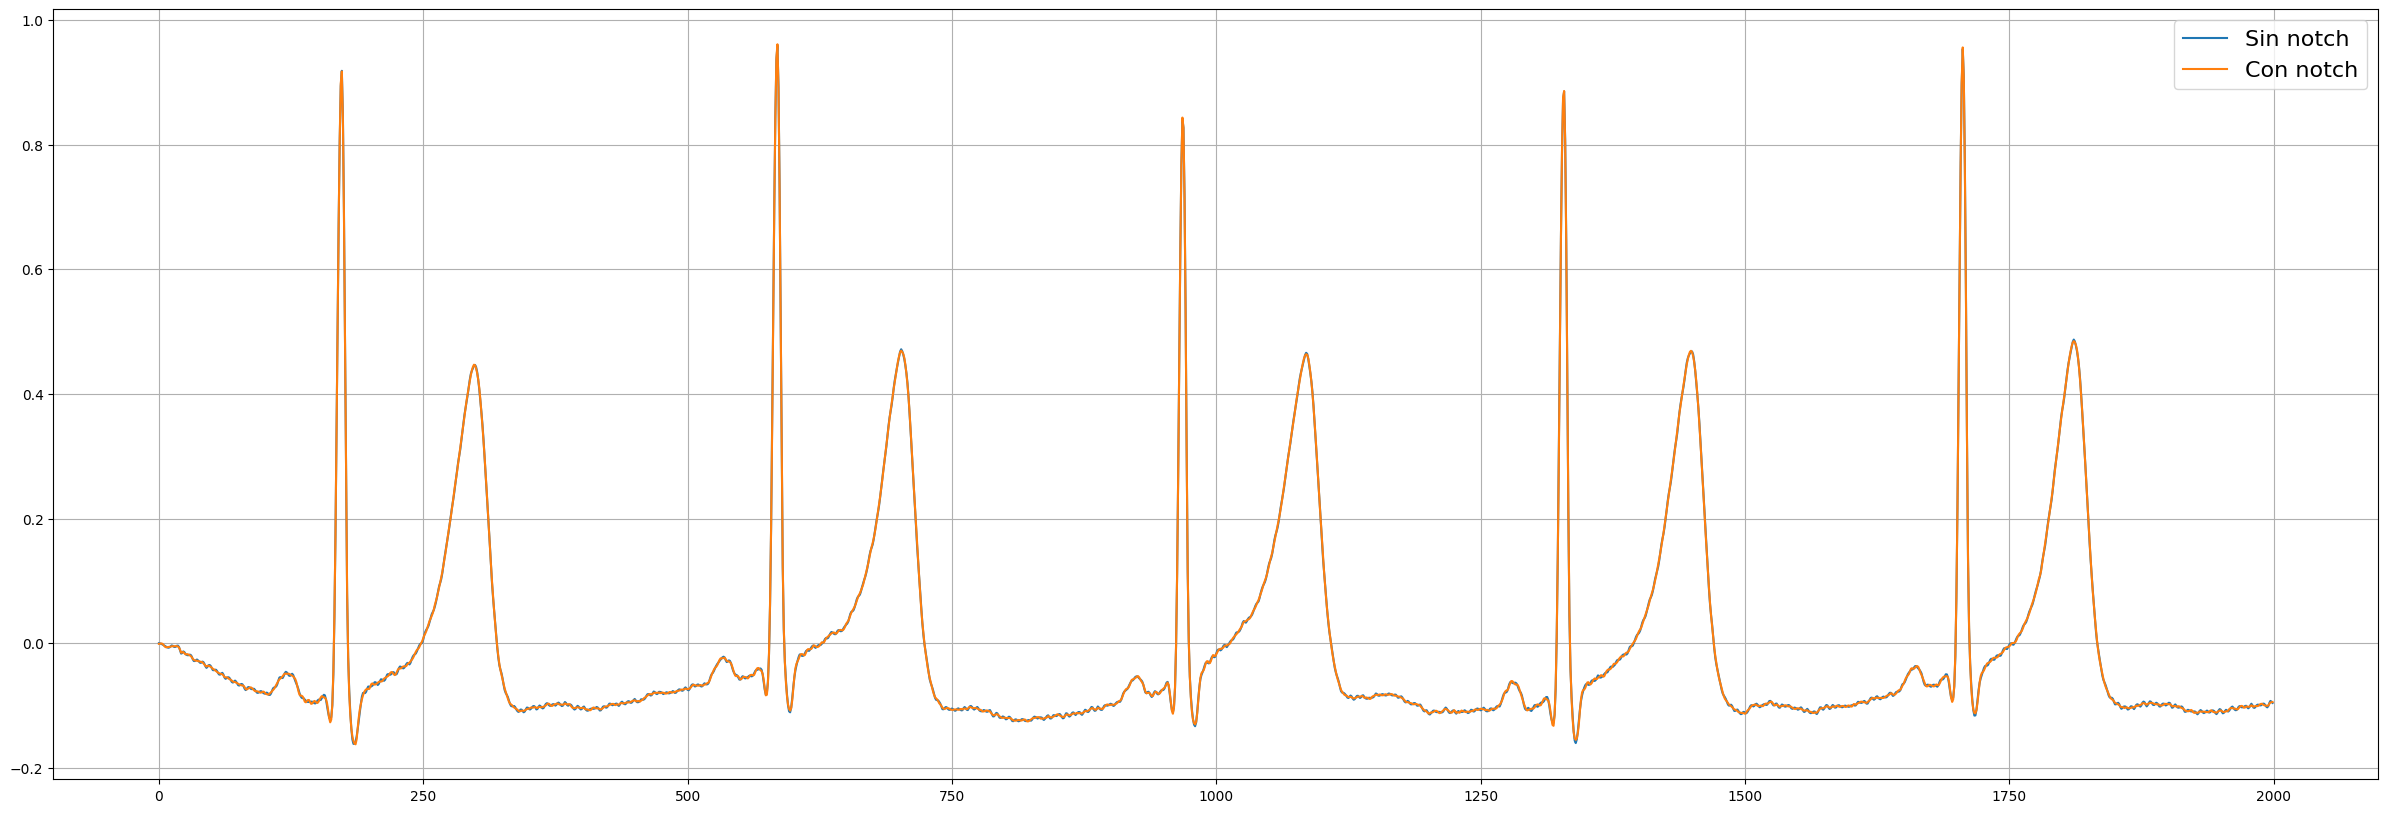

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

In [7]:
# Señal Canal 1 antes y despues del filtro notch
plt.rcParams["figure.figsize"] = (30,10)
plt.figure()
plt.plot(senal_ecg_canal_I_Normal[corte_inferior:corte_superior],label="Sin notch")
plt.plot(senal_ecg_I_filtrada[corte_inferior:corte_superior],label="Con notch")
plt.legend(fontsize=16)
plt.grid()
plt.show()
plt.figure()

# Nueva función

In [8]:
def funcion_filtro_normalizacion_FA_2(paciente,data_path):
    """Esta funcion se usa para aplicar los filtros y normalizar las señal del ECG"""
    
    #Extracción de las dos señales 
    grabacion=wfdb.rdrecord(data_path+paciente)
    senal_ecg_original=grabacion.p_signal
    #Extrayendo los dos canales de la señal
    senal_ecg_canal_I=senal_ecg_original[:,0].reshape(-1)
    senal_ecg_canal_II=senal_ecg_original[:,1].reshape(-1)

    # Parameters
    Fs = 360 # Frecuencia de muestreo
    Fc = 0.67 # Recomendada en la bibliografia
    factor = 2
    
    #Filtrado de eliminación de línea base de la señal ECG
    senal_ecg_filtrada_FIR_I,N=FIRRemoveBL(senal_ecg_canal_I,Fs,Fc,factor) #implementación filtro FIR
    senal_ecg_filtrada_FIR_II,N=FIRRemoveBL(senal_ecg_canal_II,Fs,Fc,factor) #implementación filtro FIR

    #Filtro para suavizar la señal eliminando altas frecuencias
    senal_ecg_I_filtrada=butter_lowpass_filter(senal_ecg_filtrada_FIR_I,4500,Fs,order=1)#Se filtra el primer canal de la señal Frecuencia de corte = 4500 Hz
    senal_ecg_II_filtrada=butter_lowpass_filter(senal_ecg_filtrada_FIR_II,4500,Fs,order=1)#Se filtra el primer canal de la señal Frecuencia de corte = 4500 Hz

    # Implementación del filtro notch en los dos canales
    notch_freq= 60 # Hz
    quality_factor=20.0
    samp_freq=360 # Hz
    b_notch, a_notch = signal.iirnotch(notch_freq, quality_factor, samp_freq)
    senal_ecg_I_filtrada_notch = signal.filtfilt(b_notch, a_notch, senal_ecg_I_filtrada)
    senal_ecg_II_filtrada_notch = signal.filtfilt(b_notch, a_notch, senal_ecg_II_filtrada)

    #Normalización de la señal (implementar normalizacion estandar)
    maximo_I=max(abs(senal_ecg_I_filtrada_notch))
    maximo_II=max(abs(senal_ecg_II_filtrada_notch))
    print("El maximo 1: "+str(maximo_I)+" El maximo 2: "+str(maximo_II))
    senal_ecg_I_filtrada_N=senal_ecg_I_filtrada_notch/maximo_I
    senal_ecg_II_filtrada_N=senal_ecg_II_filtrada_notch/maximo_II
    
    return senal_ecg_I_filtrada_N,senal_ecg_II_filtrada_N

El maximo 1: 2.0942090151020416 El maximo 2: 0.8338932043780226


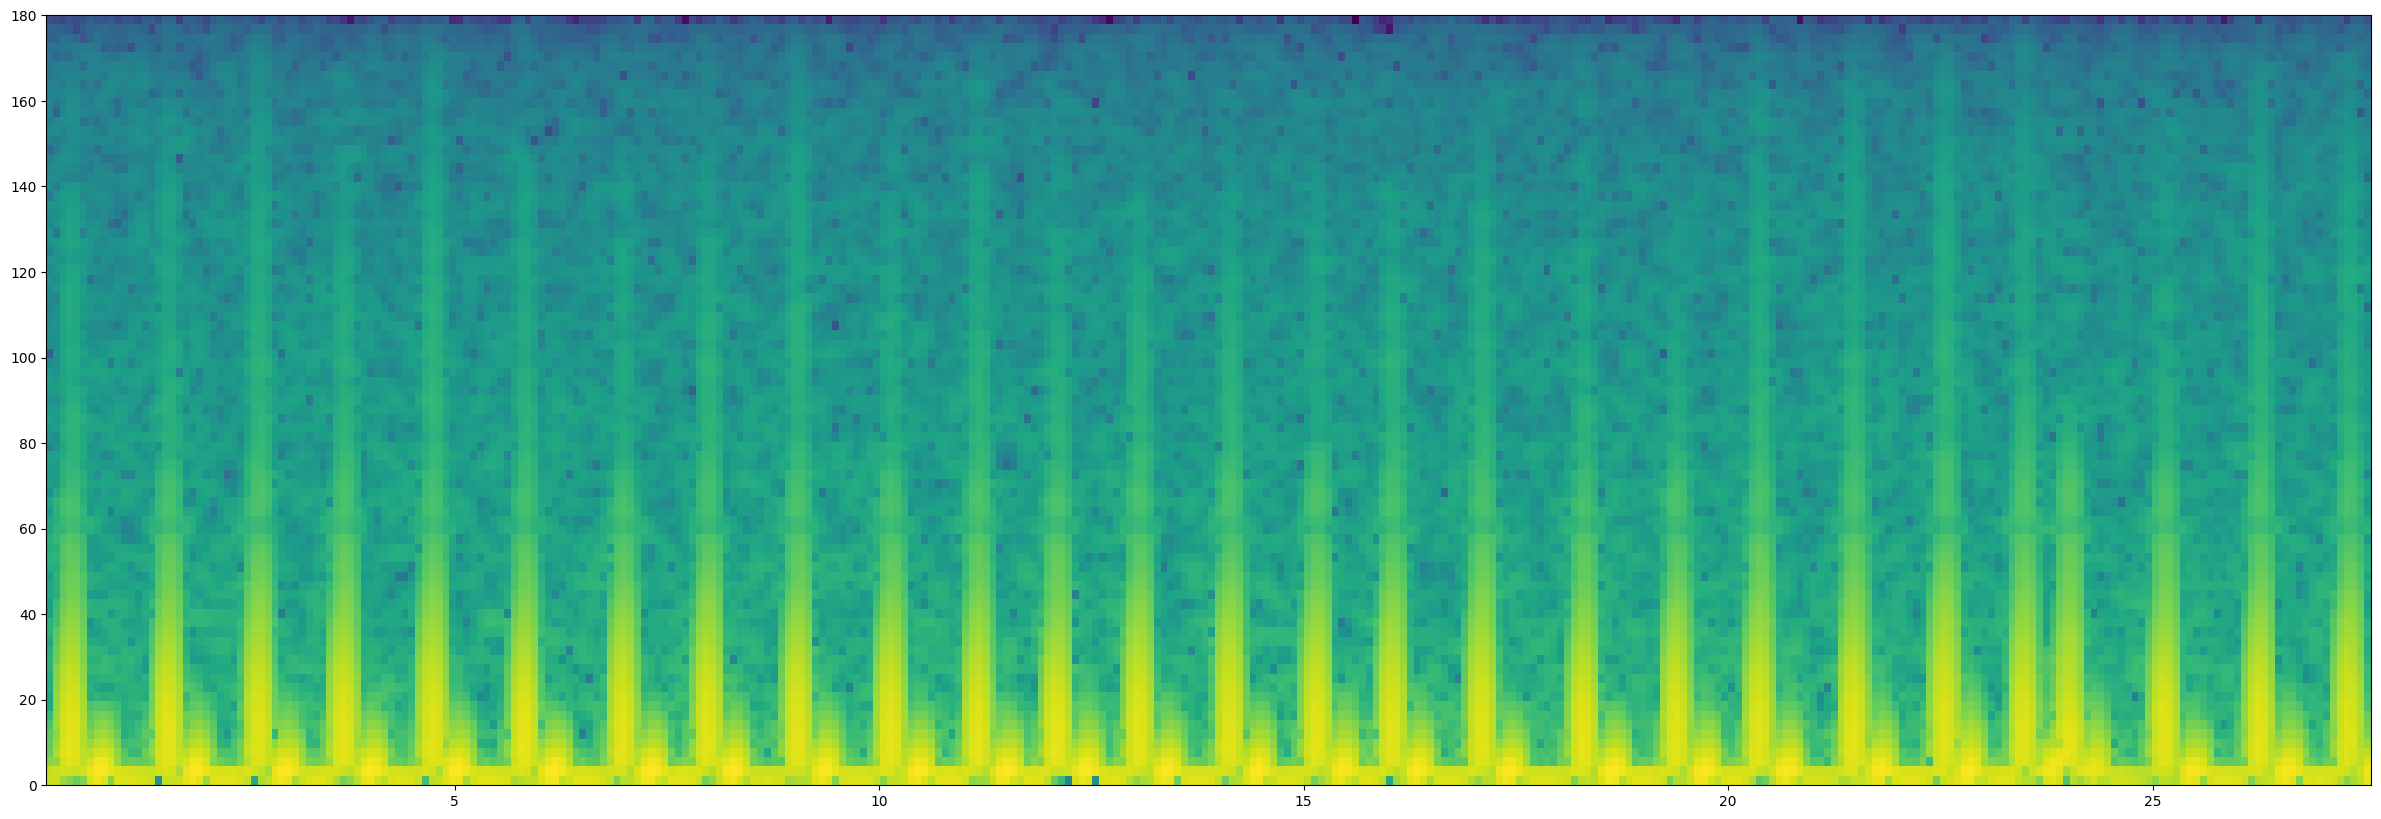

In [10]:
corte_inferior,corte_superior=0,10000
data_path='C:\\Users\\jdani\\Documents\\Escritorio\\Universidad\\Trabajo de grado\\BaseDeDatos\\mit_bih_arrhythmiadatabase\\'

#Se aplica filtro de linea base y filtro de alta frecuencia
senal_ecg_canal_I_Normal,senal_ecg_canal_II_Normal=funcion_filtro_normalizacion_FA_2('113',data_path)
# Espectrograma de canal I
a=graph_spectrogram(senal_ecg_canal_I_Normal[corte_inferior:corte_superior],360)

El maximo 1: 2.0927512145983678 El maximo 2: 0.8372844764893119


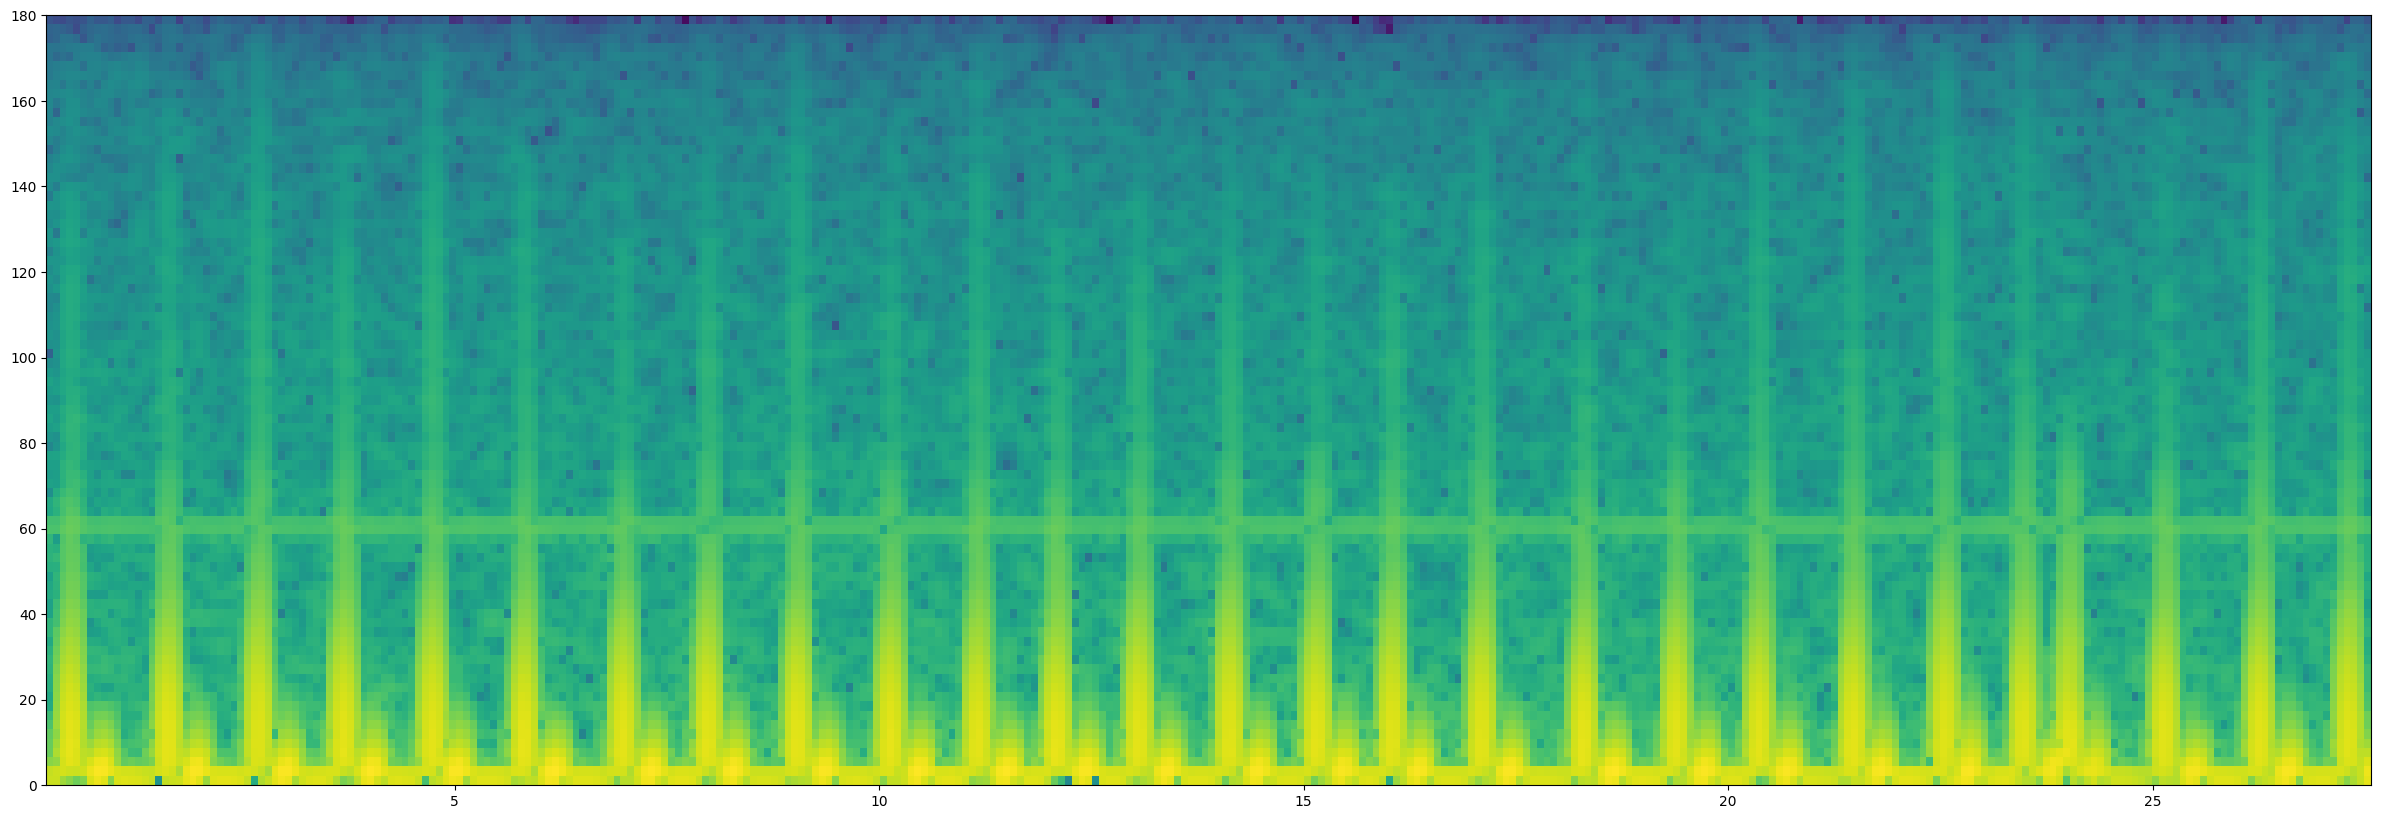

In [11]:
senal_ecg_canal_I_Normal,senal_ecg_canal_II_Normal=funcion_filtro_normalizacion_FA('113',data_path)
a=graph_spectrogram(senal_ecg_canal_I_Normal[corte_inferior:corte_superior],360)